# About the dataset

We have used OSMI dataset from a 2014 survey that measures attitudes towards mental health and frequency of mental health disorders in the tech workplace.

About OSMI: Open Sourcing Mental Illness is a non-profit, 501(c)(3) corporation dedicated to raising awareness, educating, and providing resources to support mental 
wellness in the tech and open source communities. EIN: 81-3587896

This dataset contains the following attributes:

Timestamp

Age

Gender

Country

state: If you live in the United States, which state or territory do you live in?

self_employed: Are you self-employed?

family_history: Do you have a family history of mental illness?

treatment: Have you sought treatment for a mental health condition?

work_interfere: If you have a mental health condition, do you feel that it interferes with your work?

no_employees: How many employees does your company or organization have?

remote_work: Do you work remotely (outside of an office) at least 50% of the time?

tech_company: Is your employer primarily a tech company/organization?

benefits: Does your employer provide mental health benefits?

care_options: Do you know the options for mental health care your employer provides?

wellness_program: Has your employer ever discussed mental health as part of an employee wellness program?

seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help?

anonymity: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?

leave: How easy is it for you to take medical leave for a mental health condition?

mentalhealthconsequence: Do you think that discussing a mental health issue with your employer would have negative consequences?

physhealthconsequence: Do you think that discussing a physical health issue with your employer would have negative consequences?

coworkers: Would you be willing to discuss a mental health issue with your coworkers?

supervisor: Would you be willing to discuss a mental health issue with your direct supervisor(s)?

mentalhealthinterview: Would you bring up a mental health issue with a potential employer in an interview?

physhealthinterview: Would you bring up a physical health issue with a potential employer in an interview?

mentalvsphysical: Do you feel that your employer takes mental health as seriously as physical health?

obs_consequence: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?

comments: Any additional notes or comments


## Importing Libraries for the project

In [1]:
import numpy as np #Handling data with np arrays, other algebraic manipulations
import pandas as pd #Data Processing

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

#For Pre-processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

#Models which we will try
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier


# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## Preliminary exploration of data

In [2]:
#Reading the survey dataset file
df = pd.read_csv('survey.csv')

#How many rows and columns total
print(df.shape)

#General description of data given by pandas
print(df['Age'].mean()) #this is clearly wrong so needs pre-processing

#We had some rows where age was clearly wrong and had values like 999999, -175
#Lets replace these values with 0 so that later we can fill them with mean
df.loc[(df['Age'] >= 100) | (df['Age'] < 0), 'Age'] = 0
print(df['Age'].mean())

print(df['Age'].describe())
print(df['Gender'].describe())
print(df['Country'].describe())



(1259, 27)
79428148.31135821
31.891977760127084
count    1259.000000
mean       31.891978
std         7.631065
min         0.000000
25%        27.000000
50%        31.000000
75%        36.000000
max        72.000000
Name: Age, dtype: float64
count     1259
unique      49
top       Male
freq       615
Name: Gender, dtype: object
count              1259
unique               48
top       United States
freq                751
Name: Country, dtype: object


## Data Preprocessing

In [3]:
#We have certain attributes in our dataset like timestamp, comments and state(US states only) which are not important for our project. So we are discarding them

df = df.drop(['Timestamp', 'state', 'comments'], axis=1)


In [4]:
#In all the string type attributes like 'Gender', 'Country', 'self_employed' etc. we need to put NaN wherever we have null-type data

stringAttributes = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']

for attribute in df:
    if(attribute in stringAttributes):
        df[attribute] = df[attribute].fillna('NaN')

        df.drop(df[df[attribute]==31].index, inplace=False)

#df.head(5)

In [5]:
print(df['Country'].unique())

for attribute in stringAttributes:
    df.drop(df[df[attribute]==31].index, inplace=True)

print(df['Country'].unique())


['United States' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' 'Bahamas, The' 'Greece' 'Moldova'
 'Georgia' 'China' 'Czech Republic' 'Philippines']
['United States' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' '

In [6]:
#In the survey.csv file notice that the gender attribute has a lot of problems
# for male the entries include m, M, Male, male, MaLE etc. We need to standardize the,
# as male; Similarly for female

#  furthermore there are a lot more gender groups who don't identify as male or female
#  such as tras, queer, fluid, non-binary. Let's standardize them as trans

# Gender Groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]

trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]  

female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (index, row) in df.iterrows():
    if(str.lower(row['Gender']) in male_str):
        df.loc[index, 'Gender'] = 'male'
    elif(str.lower(row['Gender']) in female_str):
        df.loc[index, 'Gender'] = 'female'
    else:
        df.loc[index, 'Gender'] = 'trans'
        

# df

In [7]:
 # Fill weird data in age with median of age
df.loc[(df['Age'] < 18) | (df['Age'] == 0)] = df['Age'].median()

# Make ranges of age
# Add new attribute age_range to df
df['age_range'] = pd.cut(df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)


In [8]:
df[['Age', 'age_range']]

,Age,age_range
0,37.0,31-65
1,44.0,31-65
2,32.0,31-65
3,31.0,31-65
4,31.0,31-65
...,...,...
1254,26.0,21-30
1255,32.0,31-65
1256,34.0,31-65
1257,46.0,31-65


In [9]:
# In self_employed attribute change NaN to Not self-employed
df['self_employed'] = df['self_employed'].replace(['NaN'], 'No')
df


,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,37.0,female,United States,No,No,Yes,Often,6-25,No,Yes,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,31-65
1,44.0,male,United States,No,No,No,Rarely,More than 1000,No,No,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,31-65
2,32.0,male,Canada,No,No,No,Rarely,6-25,No,Yes,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,31-65
3,31.0,male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,31-65
4,31.0,male,United States,No,No,No,Never,100-500,Yes,Yes,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,31-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26.0,male,United Kingdom,No,No,Yes,NaN,26-100,No,Yes,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,21-30
1255,32.0,male,United States,No,Yes,Yes,Often,26-100,Yes,Yes,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,31-65
1256,34.0,male,United States,No,Yes,Yes,Sometimes,More than 1000,No,Yes,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,31-65
1257,46.0,female,United States,No,No,No,NaN,100-500,Yes,Yes,...,Don't know,Yes,No,No,No,No,No,No,No,31-65


In [10]:
# In work_interfere change NaN or 31 to Don't know
df['work_interfere'] = df['work_interfere'].replace(['NaN', 31], f"Don't know")
df['work_interfere'].unique()



array(['Often', 'Rarely', 'Never', 'Sometimes', "Don't know"],
      dtype=object)

## Data Analysis

Let's analyze the data and draw some observations before proceeding to data visualization.

In [11]:
# Mean age of participant who took survey in each country

for attribute in stringAttributes:
    df.drop(df[df[attribute]==31].index, inplace=True)

country_data = df.groupby(df['Country'])
country_data['Age'].mean().sort_values()

# As you can see Slovenia has the youngest population working in tech who took the survey on average
# whereas Japan has the oldest population

Country
Slovenia                  19.000000
Georgia                   20.000000
Russia                    24.000000
India                     24.500000
Bosnia and Herzegovina    25.000000
Israel                    25.000000
Nigeria                   25.000000
Uruguay                   26.000000
Moldova                   26.000000
Austria                   26.666667
Sweden                    26.857143
Colombia                  27.000000
Hungary                   27.000000
Brazil                    27.333333
Bulgaria                  28.250000
Latvia                    29.000000
Romania                   29.000000
Australia                 29.000000
Canada                    29.319444
Finland                   29.333333
Belgium                   29.500000
Switzerland               29.857143
Spain                     30.000000
Germany                   30.422222
Poland                    30.428571
United Kingdom            30.940217
Philippines               31.000000
France              

In [12]:
country_data[['treatment', 'remote_work', 'self_employed']].describe()


# Observe that since data points are more for USA, Canada and Australia treatment count is high in these countries. To avoid skewed data and being country specific, let's get rid of country attribute.

df = df.drop(['Country'], axis=1)

In [13]:
df.head(5)

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,37.0,female,No,No,Yes,Often,6-25,No,Yes,Yes,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,31-65
1,44.0,male,No,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,31-65
2,32.0,male,No,No,No,Rarely,6-25,No,Yes,No,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,31-65
3,31.0,male,No,Yes,Yes,Often,26-100,No,Yes,No,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,31-65
4,31.0,male,No,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,31-65


In [14]:
# Treatment vs Age
treatment = df.groupby(df['treatment'])

treatment['Age'].describe()

# People receiving treatment for mental illness have an average age of 32 years. However we do have people as young as 18 years and as old as 72 years working in tech also receiving treatment.

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
No,619.0,31.534733,6.966401,18.0,27.0,31.0,35.0,65.0
Yes,632.0,32.607595,7.558193,18.0,27.0,32.0,37.0,72.0


In [15]:
# Treatment vs Gender

totalMales = len(df.loc[df['Gender']=='male'])
malesTreatment = len(df.loc[ ( (df['treatment'] == 'Yes') & (df['Gender'] == 'male') )])

totalFemales = len(df.loc[df['Gender']=='female'])
femalesTreatment = len(df.loc[ ( (df['treatment'] == 'Yes') & (df['Gender'] == 'female') )])



print('Percentage of males receiving treatment: ' + str( (malesTreatment/totalMales) * 100 ) + ' %') 
print('Percentage of females receiving treatment: ' + str( (femalesTreatment/totalFemales) * 100 ) + ' %') 

# percentage of males going for mental treatment = 448/986 = 45.4%
# percentage of females going for mental treatment = 170/247 = 68.82%

# Women who took the survey and are working in tech are more likely to go for mental treatment

# Note that the conclusion is not that females are more likely to suffer from a mental health problem, it just shows that women are more likely to report it.


Percentage of males receiving treatment: 45.436105476673426 %
Percentage of females receiving treatment: 68.82591093117408 %


In [16]:
# Treatment vs Family History
family = df.groupby(df['family_history'])

family['treatment'].describe()

# Percentage of people with no family history of mental illness going for treatment = (762-492)/762*100 = 35.43%
# Percentage of people with family history of mental illness going for treatment = (362)/489*100 = 74.02%

# This means that if you have a history of mental illness in your family, you're more likely to be 
# susceptible to mental illnesses and might have to seek treatment for the same.

,count,unique,top,freq
family_history,,,,
No,762,2,No,492
Yes,489,2,Yes,362


## Encoding Data

In [17]:
labelDict = {}
for feature in df:
    le = preprocessing.LabelEncoder()
    le.fit(df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    df[feature] = le.transform(df[feature])
    
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] = labelValue
    
for key, value in labelDict.items():     
    print(key, value)

df.head(3)

label_Age [18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 60.0, 61.0, 62.0, 65.0, 72.0]
label_Gender ['female', 'male', 'trans']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_employees ['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000']
label_remote_work ['No', 'Yes']
label_tech_company ['No', 'Yes']
label_benefits ["Don't know", 'No', 'Yes']
label_care_options ['No', 'Not sure', 'Yes']
label_wellness_program ["Don't know", 'No', 'Yes']
label_seek_help ["Don't know", 'No', 'Yes']
label_anonymity ["Don't know", 'No', 'Yes']
label_leave ["Don't know", 'Somewhat difficult', 'Somewhat easy', 'Very difficult', 'Very easy']
label_mental_health_consequ

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2


In [18]:
# Testing there is no missing data

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)


                           Total  Percent
age_range                      0      0.0
obs_consequence                0      0.0
Gender                         0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
care_options                   0      0.0
wellness_program               0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0      0.0
mental_vs_physical             0  

## Data Visualization

Let's draw some charts and visual representations to understand the data more clearly.

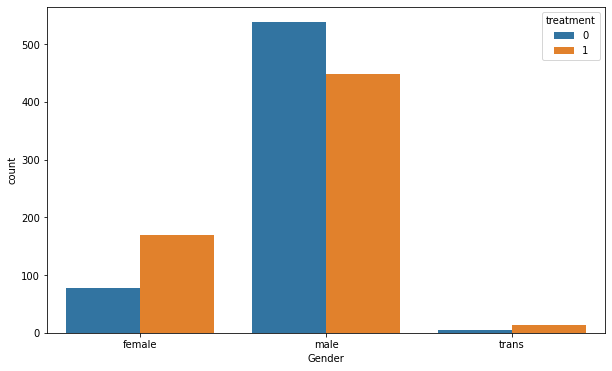

In [19]:
# Treatment vs Age

plt.figure(figsize = (10,6))
labels = labelDict['label_Gender']


g = sns.countplot(x = 'Gender', data = df, hue = 'treatment')
g.set_xticklabels(labels)
plt.show()

C:\Users\marka\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\marka\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


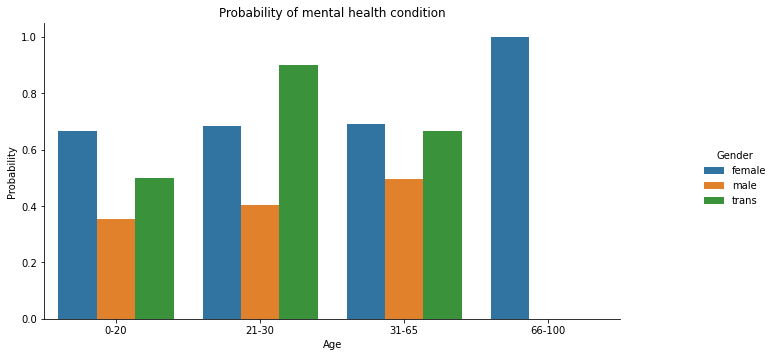

In [20]:
# Probabilities for age-range and sex

o = labelDict['label_age_range']

g = sns.factorplot(x="age_range", y="treatment", hue="Gender", data=df, kind="bar",  ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability')
plt.xlabel('Age')
# replace legend labels

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

C:\Users\marka\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\marka\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


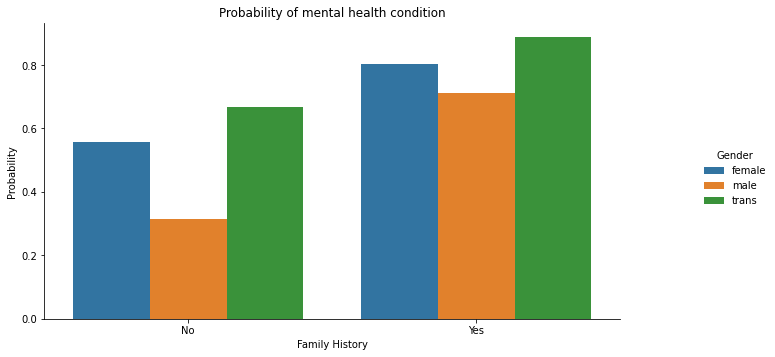

In [21]:
# Probability for family history

o = labelDict['label_family_history']
g = sns.factorplot(x="family_history", y="treatment", hue="Gender", data=df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability')
plt.xlabel('Family History')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

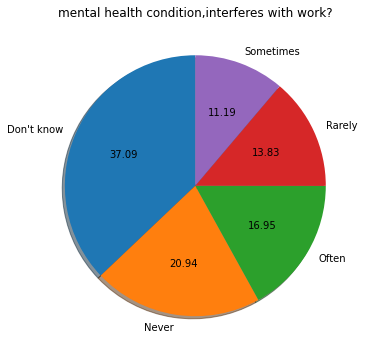

In [22]:
# Mental health condition interferes with work?

plt.figure(figsize = (10,6))
v = df['work_interfere'].value_counts()
label = labelDict['label_work_interfere']
plt.pie(v, labels = label, autopct = '%0.02f', radius = 1,shadow= True, startangle = 90)
plt.title('mental health condition,interferes with work?')
plt.show()

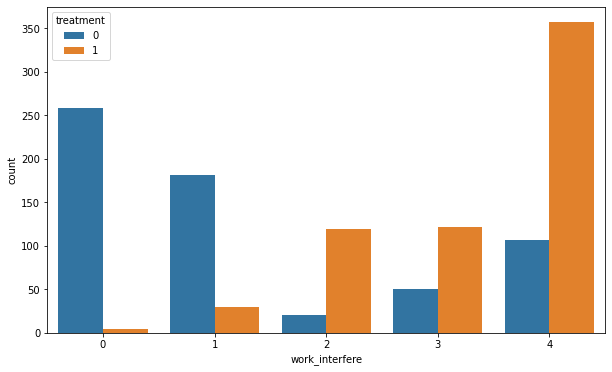

In [23]:
# work interfere vs treatment
o = labelDict['label_work_interfere']

plt.figure(figsize = (10,6))
sns.countplot(x =  'work_interfere', data = df, hue = 'treatment')
plt.show()

## Scaling Age

Since age has values very different from other attributes, we need to scale it so as to get better predictions with ML models

In [24]:
# Scaling Age


scaler = MinMaxScaler()
df['Age'] = scaler.fit_transform(df[['Age']])
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


## Splitting the dataset into training and testing data

In [25]:

# We need to define X and y as independent and dependent attributes
# Attributes in X will help us to predict attribute y
# In our case independent attributes are listed below and we will be predicting the value of "treatment" attribute.


independent_attributes = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']

X = df[independent_attributes]
y = df['treatment']

# Let's split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()


## Applying Models

In [26]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    
    #Conclusion:
    #Classification accuracy is the easiest classification metric to understand
    #But, it does not tell you the underlying distribution of response values
    #And, it does not tell you what "types" of errors your classifier is making
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################
    
    #Question: Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?
    #Answer: Plot the ROC curve!
    
    
    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        #Sensitivity: When the actual value is positive, how often is the prediction correct?
        #Specificity: When the actual value is negative, how often is the prediction correct?print('Sensitivity for ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    
    
    return accuracy

Training Accuracy:  0.8091428571428572
Accuracy: 0.7978723404255319
Null accuracy:
 1    196
0    180
Name: treatment, dtype: int64
Percentage of ones: 0.5212765957446809
Percentage of zeros: 0.4787234042553191
True: [1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0]
Pred: [1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0]


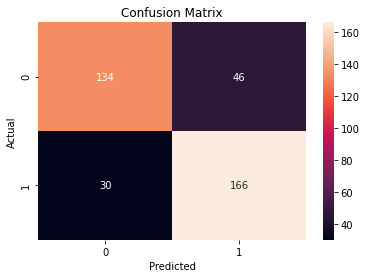

Classification Accuracy: 0.7978723404255319
Classification Error: 0.2021276595744681
False Positive Rate: 0.25555555555555554
Precision: 0.7830188679245284
AUC Score: 0.7956916099773244
Cross-validated AUC: 0.8754026618359314
First 10 predicted responses:
 [1 0 0 0 1 1 1 0 1 1]
First 10 predicted probabilities of class members:
 [[0.06818615 0.93181385]
 [0.90184609 0.09815391]
 [0.93784335 0.06215665]
 [0.85085901 0.14914099]
 [0.04319641 0.95680359]
 [0.19872074 0.80127926]
 [0.44203351 0.55796649]
 [0.93957302 0.06042698]
 [0.06025573 0.93974427]
 [0.15615177 0.84384823]]
First 10 predicted probabilities:
 [[0.93181385]
 [0.09815391]
 [0.06215665]
 [0.14914099]
 [0.95680359]
 [0.80127926]
 [0.55796649]
 [0.06042698]
 [0.93974427]
 [0.84384823]]
C:\Users\marka\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will resul

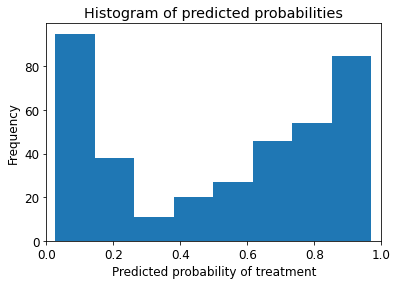

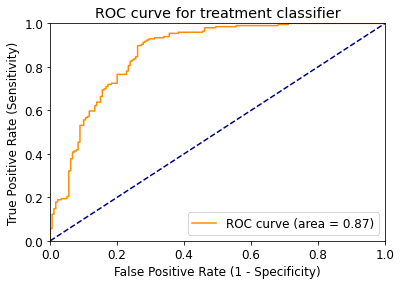

[[134  46]
 [ 30 166]]


In [27]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

test_tuple = df.iloc[0, ]
y_pred_class = logreg.predict(X_test)    

print("Training Accuracy: ",logreg.score(X_train,y_train))
accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)


Training Accuracy:  0.8308571428571428
Accuracy: 0.7952127659574468
Null accuracy:
 1    196
0    180
Name: treatment, dtype: int64
Percentage of ones: 0.5212765957446809
Percentage of zeros: 0.4787234042553191
True: [1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0]
Pred: [1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0]


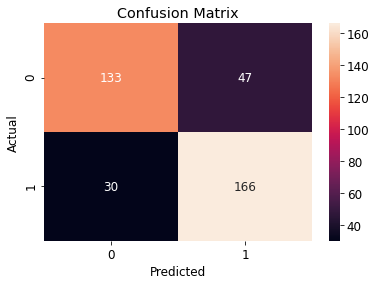

Classification Accuracy: 0.7952127659574468
Classification Error: 0.20478723404255317
False Positive Rate: 0.2611111111111111
Precision: 0.7793427230046949
AUC Score: 0.7929138321995466
Cross-validated AUC: 0.8780014609459595
First 10 predicted responses:
 [1 0 0 0 1 1 1 0 1 1]
First 10 predicted probabilities of class members:
 [[0.18518519 0.81481481]
 [0.92592593 0.07407407]
 [1.         0.        ]
 [0.85185185 0.14814815]
 [0.07407407 0.92592593]
 [0.2962963  0.7037037 ]
 [0.37037037 0.62962963]
 [1.         0.        ]
 [0.07407407 0.92592593]
 [0.37037037 0.62962963]]
First 10 predicted probabilities:
 [[0.81481481]
 [0.07407407]
 [0.        ]
 [0.14814815]
 [0.92592593]
 [0.7037037 ]
 [0.62962963]
 [0.        ]
 [0.92592593]
 [0.62962963]]
C:\Users\marka\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will resul

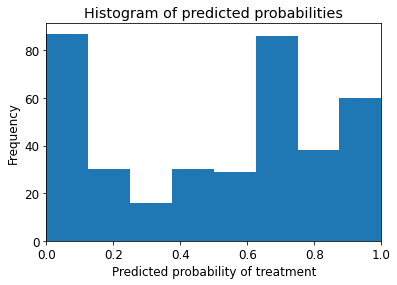

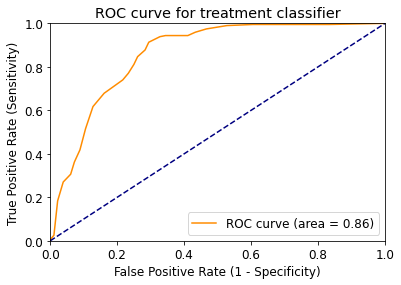

[[133  47]
 [ 30 166]]


In [28]:
# KNN


knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
    
print("Training Accuracy: ",knn.score(X_train,y_train))
accuracy_score = evalClassModel(knn, y_test, y_pred_class, True)

Training Accuracy:  0.84
Accuracy: 0.8058510638297872
Null accuracy:
 1    196
0    180
Name: treatment, dtype: int64
Percentage of ones: 0.5212765957446809
Percentage of zeros: 0.4787234042553191
True: [1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0]
Pred: [1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0]


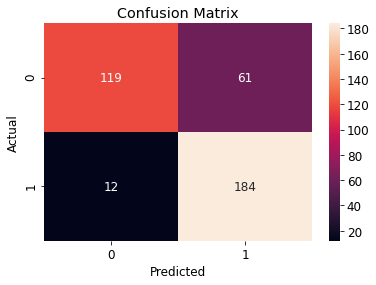

Classification Accuracy: 0.8058510638297872
Classification Error: 0.19414893617021278
False Positive Rate: 0.3388888888888889
Precision: 0.7510204081632653
AUC Score: 0.7999433106575964
Cross-validated AUC: 0.8765358294406251
First 10 predicted responses:
 [1 0 0 0 1 1 1 0 1 1]
First 10 predicted probabilities of class members:
 [[0.18604651 0.81395349]
 [1.         0.        ]
 [0.98039216 0.01960784]
 [0.98039216 0.01960784]
 [0.05660377 0.94339623]
 [0.16304348 0.83695652]
 [0.40123457 0.59876543]
 [0.98039216 0.01960784]
 [0.05660377 0.94339623]
 [0.18604651 0.81395349]]
First 10 predicted probabilities:
 [[0.81395349]
 [0.        ]
 [0.01960784]
 [0.01960784]
 [0.94339623]
 [0.83695652]
 [0.59876543]
 [0.01960784]
 [0.94339623]
 [0.81395349]]
C:\Users\marka\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will resul

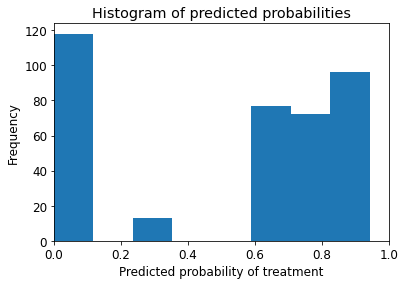

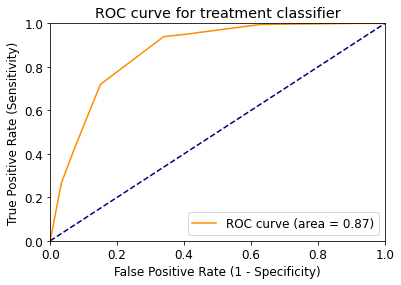

[[119  61]
 [ 12 184]]


In [29]:
# Decision Tree

tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
tree.fit(X_train, y_train)

y_pred_class = tree.predict(X_test)

print("Training Accuracy: ",tree.score(X_train,y_train))
accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

Training Accuracy:  0.8617142857142858
Accuracy: 0.8111702127659575
Null accuracy:
 1    196
0    180
Name: treatment, dtype: int64
Percentage of ones: 0.5212765957446809
Percentage of zeros: 0.4787234042553191
True: [1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0]
Pred: [1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0]


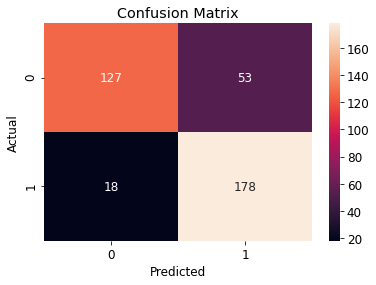

Classification Accuracy: 0.8111702127659575
Classification Error: 0.18882978723404253
False Positive Rate: 0.29444444444444445
Precision: 0.7705627705627706
AUC Score: 0.8068594104308389
Cross-validated AUC: 0.895701826556244
First 10 predicted responses:
 [1 0 0 0 1 1 1 0 1 1]
First 10 predicted probabilities of class members:
 [[0.15658987 0.84341013]
 [0.82957061 0.17042939]
 [0.89620965 0.10379035]
 [0.82729124 0.17270876]
 [0.13850609 0.86149391]
 [0.20164423 0.79835577]
 [0.3643163  0.6356837 ]
 [0.91167847 0.08832153]
 [0.13384769 0.86615231]
 [0.29977354 0.70022646]]
First 10 predicted probabilities:
 [[0.84341013]
 [0.17042939]
 [0.10379035]
 [0.17270876]
 [0.86149391]
 [0.79835577]
 [0.6356837 ]
 [0.08832153]
 [0.86615231]
 [0.70022646]]
C:\Users\marka\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will resul

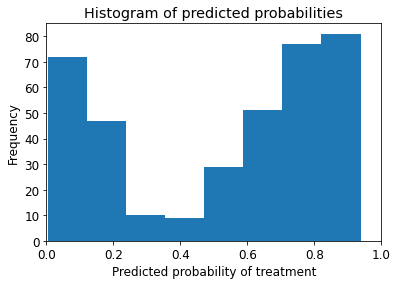

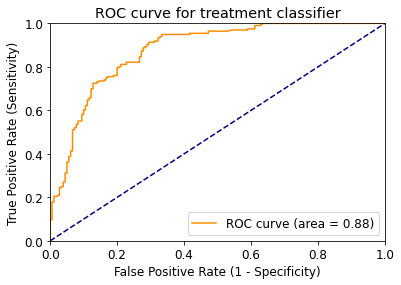

[[127  53]
 [ 18 178]]


In [30]:
#Random Forest 

forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 31, random_state = 1)
forest.fit(X_train, y_train)
    
y_pred_class = forest.predict(X_test)

print("Training Accuracy: ",forest.score(X_train,y_train))
accuracy_score = evalClassModel(forest, y_test, y_pred_class, True)